In [4]:
import pandas as pd
import numpy as np
import matplotlib as plt
import requests
import bs4
%matplotlib inline
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
import statsmodels.api as sm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import sys
reload(sys)
import csv
sys.setdefaultencoding('utf8')
#matplotlib.style.use('ggplot') 

### I have two datasets that I have collected -- All IPOs since 2007 and also the 100 most traded ETFs. I will use one or both depending on what features I decide that I want to include. For the list of IPOs I downloaded a list and imported below. I also scraped the industry for each company from nasdaq.com.

### The reason that I am not sold on the IPOs is that the purpose was to include employee satisfaction data, but I haven't found solid apples-to-apples data for this. If employee satisfaction is not included, I am better suited to use more general stocks which is why I chose highly traded ETFs as an alternative.

In [120]:
stocksdf = pd.read_csv('IPOs.csv')
stocksdf.columns=([u'Name', u'Ticker', u'Underwriter', u'# Shares(M)', u'IPO Year Close',
       u'Offer Price', u'Gain', u'IPO Date'])
stocksdf.head(2)

,Name,Ticker,Underwriter,# Shares(M),IPO Year Close,Offer Price,Gain,IPO Date
0,Atlassian Corporation Plc,TEAM,Goldman Sachs,22.0,30.21,21.0,43.86%,12/10/15
1,"Duluth Holdings, Inc.",DLTH,William Blair,6.7,14.57,12.0,21.42%,11/20/15


In [85]:
stocksdf.shape

(1334, 8)

In [86]:
url_template = 'http://www.nasdaq.com/symbol/{}/real-time'
results3 = []
results4 = []
resultsdict = {}
    
def sectorscrape(soupy):
    sec = soupy.findAll(id="qbar_sectorLabel")
    sector = []
    for i in sec:
        try:
            sector.append(i.text.strip())
        except:
            pass

    return sector


for start in list(stocksdf.Ticker):
    response = requests.get(url_template.format(start))
    page = response.text
    soup = BeautifulSoup(page,'lxml')
    theresponse = sectorscrape(soup)
    results3.append(str(start)+": "+str(theresponse))
    resultsdict.update({start:theresponse})

In [87]:
industrydf = pd.DataFrame()
for i in range(len(results3)):
    industrydf[i] = [results3[i],results3[i][:results3[i].find(":")],results3[i][results3[i].find("y: ")+3:-2]]

In [88]:
industrydf = industrydf.T
industrydf.columns = (['Result','Ticker','Industry'])

In [89]:
industrydf['Industry'] = industrydf.Industry.apply(lambda x: np.nan if ":" in x else x)

In [90]:
#industrydf = industrydf.dropna()
stocksdf = pd.merge(stocksdf, industrydf, on='Ticker', how='left')

In [92]:
del stocksdf['Result']
del stocksdf['IPO Year Close']
del stocksdf['Gain']

In [93]:
stocksdf.to_csv('stocksdf.csv')

In [94]:
stocksdf = pd.read_csv('stocksdf.csv')

In [96]:
import pandas_datareader.data as web
import datetime
from datetime import timedelta
from pandas.tseries.offsets import BDay

### I want to get the stock price at varying intervals from the IPO. The below functions get the dates of interest as well as the price at those dates.

In [97]:
stocksdf['1d'] = stocksdf['IPO Date'].apply(lambda x: pd.to_datetime(x) + timedelta(1))
stocksdf['7d'] = stocksdf['IPO Date'].apply(lambda x: pd.to_datetime(x) + timedelta(7))
stocksdf['30d'] = stocksdf['IPO Date'].apply(lambda x: pd.to_datetime(x) + timedelta(30))
stocksdf['60d'] = stocksdf['IPO Date'].apply(lambda x: pd.to_datetime(x) + timedelta(60))
stocksdf['90d'] = stocksdf['IPO Date'].apply(lambda x: pd.to_datetime(x) + timedelta(90))
stocksdf['180d'] = stocksdf['IPO Date'].apply(lambda x: pd.to_datetime(x) + timedelta(180))

In [101]:
mylist = []
def pricelookup(date,ticker):
    for i in range(5):
        try:
            start = datetime.datetime(date.year, date.month,(date.day)+i)
            a = web.DataReader(ticker, 'yahoo',start,start)
            return a.Close[0]
        except:
            pass
    return np.nan

stocksdf['1day'] = stocksdf.apply(lambda row: pricelookup(row['1d'], row['Ticker']), axis=1)
stocksdf['7days'] = stocksdf.apply(lambda row: pricelookup(row['7d'], row['Ticker']), axis=1)
stocksdf['30days'] = stocksdf.apply(lambda row: pricelookup(row['30d'], row['Ticker']), axis=1)
stocksdf['60days'] = stocksdf.apply(lambda row: pricelookup(row['60d'], row['Ticker']), axis=1)
stocksdf['90days'] = stocksdf.apply(lambda row: pricelookup(row['90d'], row['Ticker']), axis=1)
stocksdf['180days'] = stocksdf.apply(lambda row: pricelookup(row['180d'], row['Ticker']), axis=1)

In [102]:
stocksdf.to_csv('stocksdf.csv')

In [103]:
stocksdf = pd.read_csv('stocksdf.csv')

In [105]:
del stocksdf['Unnamed: 0']
del stocksdf['Unnamed: 0.1']

In [136]:
url_template = 'https://www.glassdoor.com/Award/Best-Places-to-Work-{}-LST_KQ0,24.htm'
bestplaceslist = []
    
def bestplaces(soupy):
    bp = soupy.findAll(class_="strong tightTop margBotSm")
    bestplaces = []
    for i in bp:
        try:
            bestplaces.append(i.text.strip())
        except:
            pass

    return bestplaces

years = ['2009','2010','2011','2012','2013','2014','2015','2016']
for start in years:
    response = requests.get(url_template.format(start))
    page = response.text
    soup = BeautifulSoup(page,'lxml')
    bestplaceslist.append(bestplaces(soup))

In [107]:
bestplacestowork = pd.read_csv('bestplacestowork.csv')

In [109]:
del bestplacestowork['Unnamed: 4']
del bestplacestowork['Unnamed: 5']
del bestplacestowork['Unnamed: 6']

In [110]:
stocksdf['Best2015'] = stocksdf.Name.apply(lambda x: 1 if x in list(bestplacestowork['2015']) else 0)
stocksdf['Best2014'] = stocksdf.Name.apply(lambda x: 1 if x in list(bestplacestowork['2014']) else 0)
stocksdf['Best2013'] = stocksdf.Name.apply(lambda x: 1 if x in list(bestplacestowork['2013']) else 0)
stocksdf['Best2012'] = stocksdf.Name.apply(lambda x: 1 if x in list(bestplacestowork['2012']) else 0)

### I have removed most of my EDA but left a few graphs below.

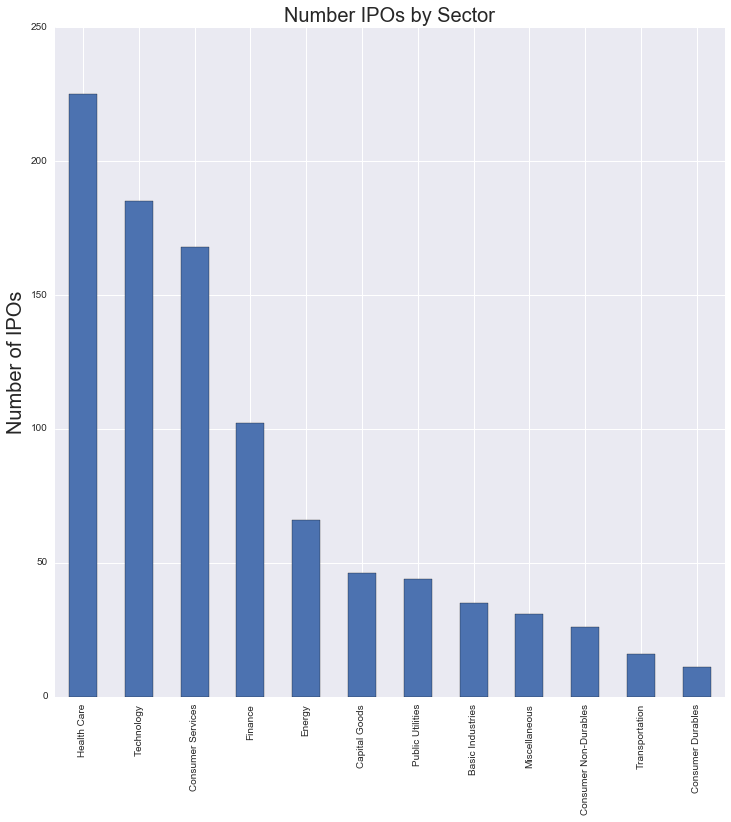

In [206]:
stocksdf.Industry.value_counts().plot(kind = "bar",figsize = (12,12))
plt.ylabel('Number of IPOs',fontsize=20)
plt.title('Number IPOs by Sector',fontsize=20)

In [248]:
stocksdf['Percent180'] = stocksdf['180days']*100/stocksdf['Offer Price']
stocksdf['Percent7'] = stocksdf['7days']*100/stocksdf['Offer Price']

In [253]:
stockspivot1= pd.pivot_table(stocksdf[stocksdf['Offer Price']!=0],values=['Percent180','Percent7'],index=['Industry'],aggfunc=np.mean)

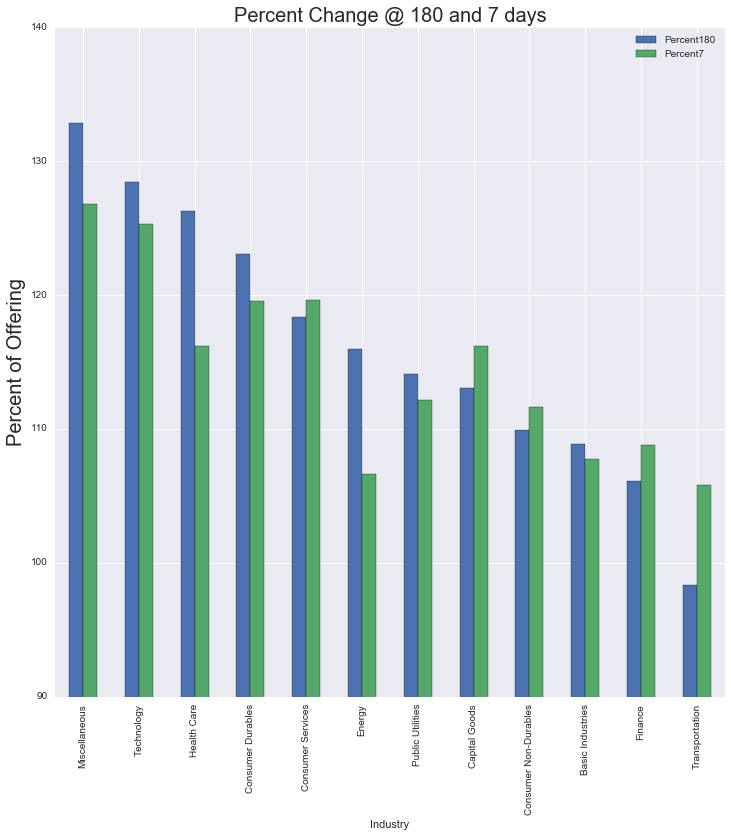

In [256]:
stockspivot1.sort_values(['Percent180'],ascending=False).plot(kind='bar',figsize =(12,12))
axes = plt.gca()
axes.set_ylim([90,140])
plt.ylabel('Percent of Offering',fontsize=20)
plt.title('Percent Change @ 180 and 7 days',fontsize=20)

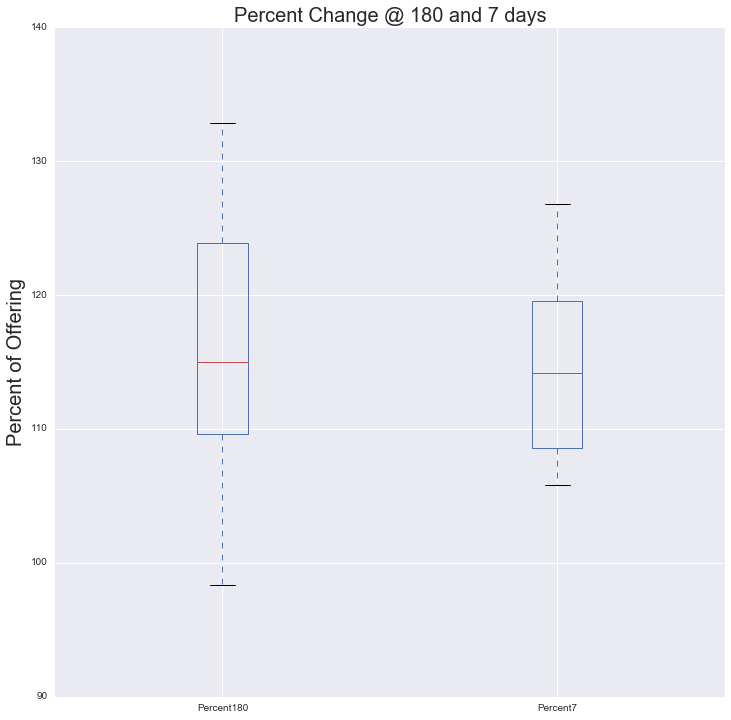

In [257]:
stockspivot1.sort_values(['Percent180'],ascending=False).plot(kind='box',figsize =(12,12))
axes = plt.gca()
axes.set_ylim([90,140])
plt.ylabel('Percent of Offering',fontsize=20)
plt.title('Percent Change @ 180 and 7 days',fontsize=20)

In [32]:
iposperyear2 = pd.pivot_table(stocksdf, index = ['Industry'],values = ['IPO Year'],aggfunc=len,margins =True)

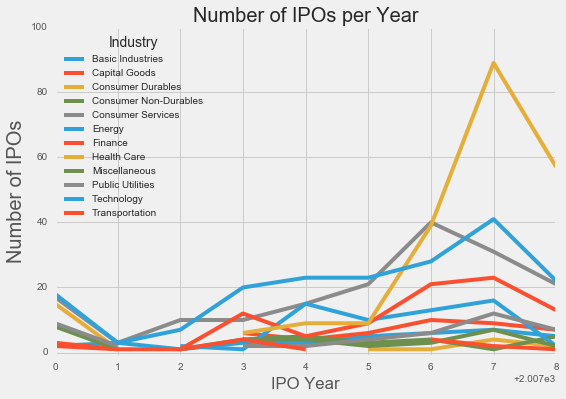

In [80]:
iposperyear = pd.pivot_table(stocksdf, index = ['Industry'],columns = ['IPO Year'],aggfunc=len,margins =True)
iposperyear=iposperyear['Unnamed: 0']
iposperyear=iposperyear.reset_index()
del iposperyear['All']
iposperyear = iposperyear[:-1]
iposperyear = iposperyear.set_index(["Industry"])
iposperyear.T.plot(kind='line')
axes = plt.gca()
axes.set_ylim([-1,100])
plt.ylabel('Number of IPOs',fontsize=20)
plt.title('Number of IPOs per Year',fontsize=20)
plt.style.use('fivethirtyeight')

### The below imports a second set of data (the 100 most traded ETFs) as well as calculating the RSI (relative strength index) which a strong indicator of a stock's momentum. The 'numberrsis' variable is the number of days in the past to get this value. This will be important for testing the accuracy of the model.

In [5]:
import pandas_datareader.data as web
import datetime
etfs = pd.read_csv('etflist.csv')

def getrsi(ticker,i):
    period = datetime.timedelta(days=40)
    end = datetime.date.today()
    start = end - period
    tick = web.DataReader(ticker, 'yahoo', start, end)
    del tick['Open']
    del tick['High']
    del tick['Low']
    del tick['Close']
    tick.columns = [['volume','close']]
    tick['yesterdayclose'] = tick.close.shift(1)
    tick['gainloss'] = tick.close - tick.yesterdayclose
    tick['gain'] = tick.gainloss.apply(lambda x: x if x > 0 else 0)
    tick['loss'] = tick.gainloss.apply(lambda x: -x if x < 0 else 0)
    del tick['gainloss']
    tick['avggain'] = pd.rolling_sum(tick.gain, 14)/14
    tick['avgloss'] = pd.rolling_sum(tick.loss, 14)/14
    tick['RS'] = tick.avggain/tick.avgloss
    tick['RSI'] = 100-(100/(1+tick.RS))
    return tick.RSI[-i]

numberrsis = 10
for i in range(numberrsis):
    i = str(i+1)
    etfs['RSI'+i] = etfs.apply(lambda row: getrsi(row['Symbol'], int(i)), axis=1)

KeyboardInterrupt: 

### The below calculates volatility index (though not exactly working yet.. there is a syntactical error in passing the date argument to the vix() function). I think this will be a key feature in my model.

In [6]:
import pandas_datareader.data as web
import datetime

def vix(ticker,datey):
    datey = pd.to_datetime(datey)
    vix = web.DataReader('vix', 'yahoo', datey,datey)
    return vix['Adj Close'][0]
    
def getstockdf(ticker):
    period = datetime.timedelta(days=100)
    end = datetime.date.today()
    start = end - period
    tick = web.DataReader(ticker, 'yahoo', start, end)
    del tick['Open']
    del tick['High']
    del tick['Low']
    del tick['Close']
    tick.columns = [['volume','close']]
    tick = tick.reset_index()
    tick['yesterdayclose'] = tick.close.shift(1)
    tick['gainloss'] = tick.close - tick.yesterdayclose
    tick['rsi'] = tick.apply(lambda row: getdayrsi(str(ticker), str(row['Date'])), axis=1)
    tick['vix'] = tick.apply(lambda row: vix(ticker,str(row['Date'])))
    del tick['close']
    return ticker


### The next step is to create a target -- a simple binary if the stock went up or down that day. I can use any classification model. I will likely run a logistic regression model as well as various decision trees to determine which most accurately predicts the direction of each stock.

### Conclusion - I am a little concerned at this point about not being able to find acceptable employee satisfaction data to use as a feature. Without it, I'm just building a model that uses market indicators to predic the direction of the market the following day -- like everyone else has been doing for a long time. It's not really exciting nor do I put a whole lot of faith in it.

In [7]:
getstockdf('tsla')

NameError: ("global name 'getdayrsi' is not defined", u'occurred at index 0')